# Feature Selection & Model Training
**Purpose**: Analyze feature quality, remove redundant/collinear features, and train linear models

## Pipeline
1. Load prepared dataset
2. Correlation analysis (feature-feature + feature-target)
3. VIF (Variance Inflation Factor) analysis
4. Mutual information with target
5. Feature selection summary & final feature set
6. Train models on selected features
7. Compare with full-feature baseline

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import json
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import mutual_info_regression
import joblib

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Libraries loaded')

✓ Libraries loaded


In [41]:
# === Configuration ===
DATA_DIR = Path('/home/archy/Desktop/Server/FinancialData/model_regime_comparison/data/prepared')
MODEL_DIR = Path('/home/archy/Desktop/Server/FinancialData/model_regime_comparison/models')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TARGET = 'forward_return_30d'
EXCLUDE_COLS = ['ticker', 'date', 'close', 'forward_return_5d', 'forward_return_30d']

# Feature selection thresholds
CORR_THRESHOLD = 0.90       # Drop one of a pair if |corr| > this
VIF_THRESHOLD = 10.0        # Flag features with VIF > this
TARGET_CORR_MIN = 0.01      # Minimum |correlation| with target to keep

print(f'Data dir: {DATA_DIR}')
print(f'Target: {TARGET}')
print(f'Correlation threshold: {CORR_THRESHOLD}')
print(f'VIF threshold: {VIF_THRESHOLD}')

Data dir: /home/archy/Desktop/Server/FinancialData/model_regime_comparison/data/prepared
Target: forward_return_30d
Correlation threshold: 0.9
VIF threshold: 10.0


## 1. Load Data

In [42]:
train_df = pd.read_parquet(DATA_DIR / 'finance_train.parquet')
val_df = pd.read_parquet(DATA_DIR / 'finance_val.parquet')
test_df = pd.read_parquet(DATA_DIR / 'finance_test.parquet')

print(f'Train: {train_df.shape}')
print(f'Val:   {val_df.shape}')
print(f'Test:  {test_df.shape}')
print(f'\nColumns: {list(train_df.columns)}')

Train: (11580, 41)
Val:   (1240, 41)
Test:  (980, 41)

Columns: ['momentum_5d', 'momentum_20d', 'momentum_60d', 'volatility_20d', 'volatility_60d', 'rsi_14', 'macd_line', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_percent_b', 'price_to_sma_20', 'price_to_sma_50', 'price_to_sma_200', 'volume_trend', 'has_data', 'sector', 'industry', 'country', 'exchange', 'has_filings', 'avg_filing_size', 'filing_frequency', 'pe_ratio', 'debt_equity_ratio', 'current_ratio', 'roe', 'roa', 'asset_turnover', 'profit_margin', 'free_cash_flow_yield', 'revenue_growth', 'earnings_growth', 'sector_rotation', 'ticker', 'date', 'close', 'forward_return_5d', 'forward_return_30d']


In [43]:
# Identify feature columns (numeric only)
all_feature_cols = [c for c in train_df.columns if c not in EXCLUDE_COLS]
numeric_features = train_df[all_feature_cols].select_dtypes(include=[np.number]).columns.tolist()

# Drop any constant or near-constant features
std = train_df[numeric_features].std()
constant_cols = std[std < 1e-10].index.tolist()
if constant_cols:
    print(f'Dropping {len(constant_cols)} constant features: {constant_cols}')
    numeric_features = [c for c in numeric_features if c not in constant_cols]

print(f'Numeric features for analysis: {len(numeric_features)}')
print(f'Non-numeric columns excluded: {set(all_feature_cols) - set(numeric_features)}')

Dropping 3 constant features: ['has_data', 'has_filings', 'filing_frequency']
Numeric features for analysis: 29
Non-numeric columns excluded: {'sector', 'industry', 'has_data', 'has_filings', 'filing_frequency', 'country', 'exchange'}


In [44]:
# Prepare X/y from training set (fill NaN for analysis)
X_train_raw = train_df[numeric_features].copy()
y_train = train_df[TARGET].copy()

# Report missing values
missing = X_train_raw.isnull().sum()
missing_pct = (missing / len(X_train_raw) * 100)
if missing.any():
    print('Missing values per feature:')
    print(missing[missing > 0].sort_values(ascending=False).to_string())
else:
    print('No missing values in numeric features')

# Fill NaN with median for analysis
X_analysis = X_train_raw.fillna(X_train_raw.median())
y_analysis = y_train.fillna(y_train.median())

# Drop columns that still contain NaN (e.g. entirely NaN columns where median is NaN)
still_nan = X_analysis.columns[X_analysis.isnull().any()].tolist()
if still_nan:
    print(f'Dropping {len(still_nan)} columns still containing NaN after median fill: {still_nan}')
    X_analysis = X_analysis.drop(columns=still_nan)
    numeric_features = [c for c in numeric_features if c not in still_nan]
print(f'\nAnalysis matrix: {X_analysis.shape}')

Missing values per feature:
avg_filing_size         11580
pe_ratio                11580
debt_equity_ratio       11580
current_ratio           11580
roe                     11580
roa                     11580
asset_turnover          11580
profit_margin           11580
free_cash_flow_yield    11580
revenue_growth          11580
earnings_growth         11580
sector_rotation         11580
Dropping 12 columns still containing NaN after median fill: ['avg_filing_size', 'pe_ratio', 'debt_equity_ratio', 'current_ratio', 'roe', 'roa', 'asset_turnover', 'profit_margin', 'free_cash_flow_yield', 'revenue_growth', 'earnings_growth', 'sector_rotation']

Analysis matrix: (11580, 17)


## 2. Correlation Analysis

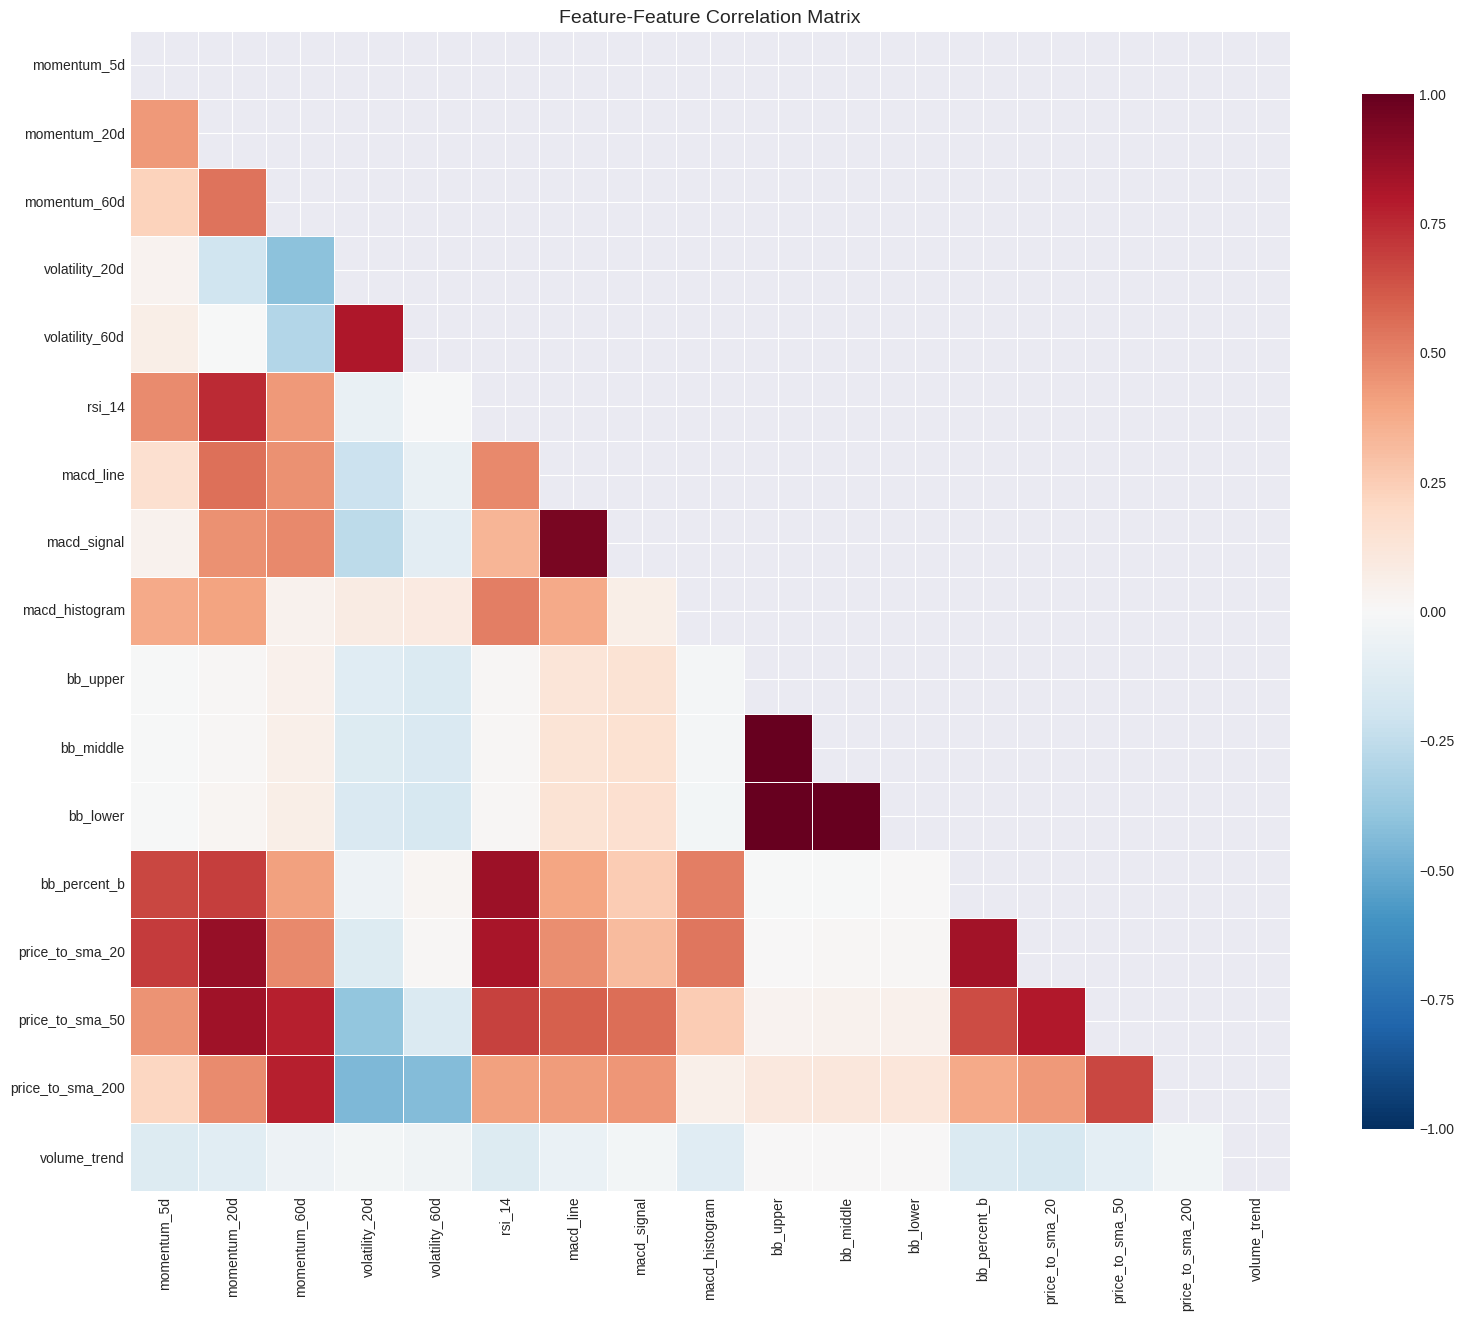

In [45]:
# Feature-feature correlation matrix
corr_matrix = X_analysis.corr()

# Plot full heatmap
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            vmin=-1, vmax=1, annot=False, square=True,
            linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Feature-Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

In [46]:
# Identify highly correlated pairs
upper = corr_matrix.where(mask).abs()
high_corr_pairs = []
for col in upper.columns:
    for row in upper.index:
        if row != col and upper.loc[row, col] > CORR_THRESHOLD:
            high_corr_pairs.append({
                'feature_1': row,
                'feature_2': col,
                'correlation': corr_matrix.loc[row, col]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).drop_duplicates(
    subset=['correlation']).sort_values('correlation', key=abs, ascending=False)

print(f'Highly correlated pairs (|r| > {CORR_THRESHOLD}): {len(high_corr_df)}')
if len(high_corr_df) > 0:
    print(high_corr_df.to_string(index=False))

Highly correlated pairs (|r| > 0.9): 4
feature_1   feature_2  correlation
 bb_upper   bb_middle     0.999192
bb_middle    bb_lower     0.998973
 bb_upper    bb_lower     0.996345
macd_line macd_signal     0.949594


In [47]:
# Decide which feature to drop from each correlated pair
# Strategy: keep the one with higher absolute correlation to the target
target_corr = X_analysis.corrwith(y_analysis).abs()

features_to_drop_corr = set()
for _, row in high_corr_df.iterrows():
    f1, f2 = row['feature_1'], row['feature_2']
    if f1 in features_to_drop_corr or f2 in features_to_drop_corr:
        continue  # already marked for removal
    # Drop the one less correlated with target
    if target_corr.get(f1, 0) >= target_corr.get(f2, 0):
        features_to_drop_corr.add(f2)
        print(f'  Drop {f2} (keep {f1}, target corr: {target_corr.get(f1, 0):.4f} vs {target_corr.get(f2, 0):.4f})')
    else:
        features_to_drop_corr.add(f1)
        print(f'  Drop {f1} (keep {f2}, target corr: {target_corr.get(f2, 0):.4f} vs {target_corr.get(f1, 0):.4f})')

print(f'\nFeatures to drop (high correlation): {len(features_to_drop_corr)}')
remaining_after_corr = [c for c in numeric_features if c not in features_to_drop_corr]
print(f'Remaining features: {len(remaining_after_corr)}')

  Drop bb_upper (keep bb_middle, target corr: 0.0236 vs 0.0196)
  Drop bb_middle (keep bb_lower, target corr: 0.0280 vs 0.0236)
  Drop macd_signal (keep macd_line, target corr: 0.0860 vs 0.0849)

Features to drop (high correlation): 3
Remaining features: 14


## 3. VIF Analysis
Variance Inflation Factor measures multicollinearity. VIF > 10 suggests problematic collinearity.

In [48]:
def compute_vif(X):
    """Compute VIF from correlation matrix inverse.
    VIF_i = diag(inv(corr_matrix))_i
    Drops zero-variance columns and any with NaN correlations first.
    """
    # Remove constant columns (zero variance produces NaN in corr)
    X = X.loc[:, X.std() > 1e-10]
    corr = X.corr()
    # Drop features that still have NaN correlations
    valid_mask = ~corr.isnull().any(axis=0)
    if valid_mask.sum() < corr.shape[0]:
        dropped = corr.columns[~valid_mask].tolist()
        print(f'  VIF: dropping {len(dropped)} features with NaN correlations: {dropped}')
        corr = corr.loc[valid_mask, valid_mask]
    try:
        inv_corr = np.linalg.inv(corr.values)
    except np.linalg.LinAlgError:
        # Singular matrix - use pseudoinverse
        inv_corr = np.linalg.pinv(corr.values)
    vif_values = np.diag(inv_corr)
    return pd.Series(vif_values, index=corr.columns)

# Compute VIF on remaining features
X_remaining = X_analysis[remaining_after_corr]
vif = compute_vif(X_remaining)
vif_df = pd.DataFrame({'Feature': vif.index, 'VIF': vif.values}).sort_values('VIF', ascending=False)

print('VIF Analysis (after removing highly correlated features):')
print('=' * 50)
print(vif_df.to_string(index=False))
print('=' * 50)

high_vif = vif_df[vif_df['VIF'] > VIF_THRESHOLD]
print(f'\nFeatures with VIF > {VIF_THRESHOLD}: {len(high_vif)}')
if len(high_vif) > 0:
    print(high_vif.to_string(index=False))

VIF Analysis (after removing highly correlated features):
         Feature       VIF
 price_to_sma_20 14.799154
 price_to_sma_50 11.362545
    momentum_20d  7.289708
    bb_percent_b  5.945231
          rsi_14  5.675353
  volatility_20d  4.530782
  volatility_60d  4.165611
    momentum_60d  4.102515
     momentum_5d  3.180281
price_to_sma_200  3.178148
       macd_line  1.967108
  macd_histogram  1.908069
        bb_lower  1.065852
    volume_trend  1.035568

Features with VIF > 10.0: 2
        Feature       VIF
price_to_sma_20 14.799154
price_to_sma_50 11.362545


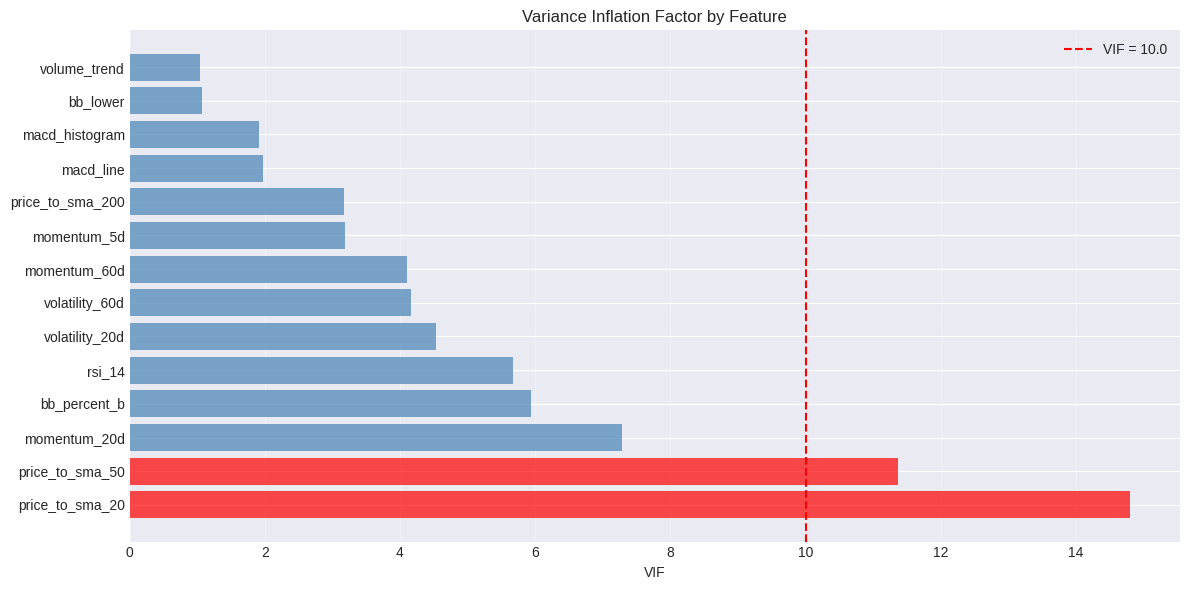

In [49]:
# Plot VIF
fig, ax = plt.subplots(figsize=(12, max(6, len(vif_df) * 0.3)))
colors = ['red' if v > VIF_THRESHOLD else 'steelblue' for v in vif_df['VIF']]
ax.barh(range(len(vif_df)), vif_df['VIF'], color=colors, alpha=0.7)
ax.set_yticks(range(len(vif_df)))
ax.set_yticklabels(vif_df['Feature'])
ax.axvline(VIF_THRESHOLD, color='red', linestyle='--', linewidth=1.5, label=f'VIF = {VIF_THRESHOLD}')
ax.set_xlabel('VIF')
ax.set_title('Variance Inflation Factor by Feature')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

In [50]:
# Iteratively remove highest-VIF features until all VIF < threshold
features_to_drop_vif = set()
current_features = remaining_after_corr.copy()

max_iterations = 20
for iteration in range(max_iterations):
    X_temp = X_analysis[current_features]
    vif_temp = compute_vif(X_temp)
    max_vif = vif_temp.max()
    max_vif_feature = vif_temp.idxmax()
    
    if max_vif <= VIF_THRESHOLD:
        print(f'\nAll VIF values <= {VIF_THRESHOLD} after {iteration} removals')
        break
    
    print(f'  Iteration {iteration+1}: Dropping {max_vif_feature} (VIF={max_vif:.1f})')
    features_to_drop_vif.add(max_vif_feature)
    current_features = [c for c in current_features if c != max_vif_feature]
else:
    print(f'Warning: max iterations reached, some VIF may still be > {VIF_THRESHOLD}')

remaining_after_vif = current_features
print(f'\nDropped by VIF: {features_to_drop_vif}')
print(f'Remaining features: {len(remaining_after_vif)}')

  Iteration 1: Dropping price_to_sma_20 (VIF=14.8)
  Iteration 2: Dropping price_to_sma_50 (VIF=10.4)

All VIF values <= 10.0 after 2 removals

Dropped by VIF: {'price_to_sma_20', 'price_to_sma_50'}
Remaining features: 12


## 4. Feature-Target Relationship

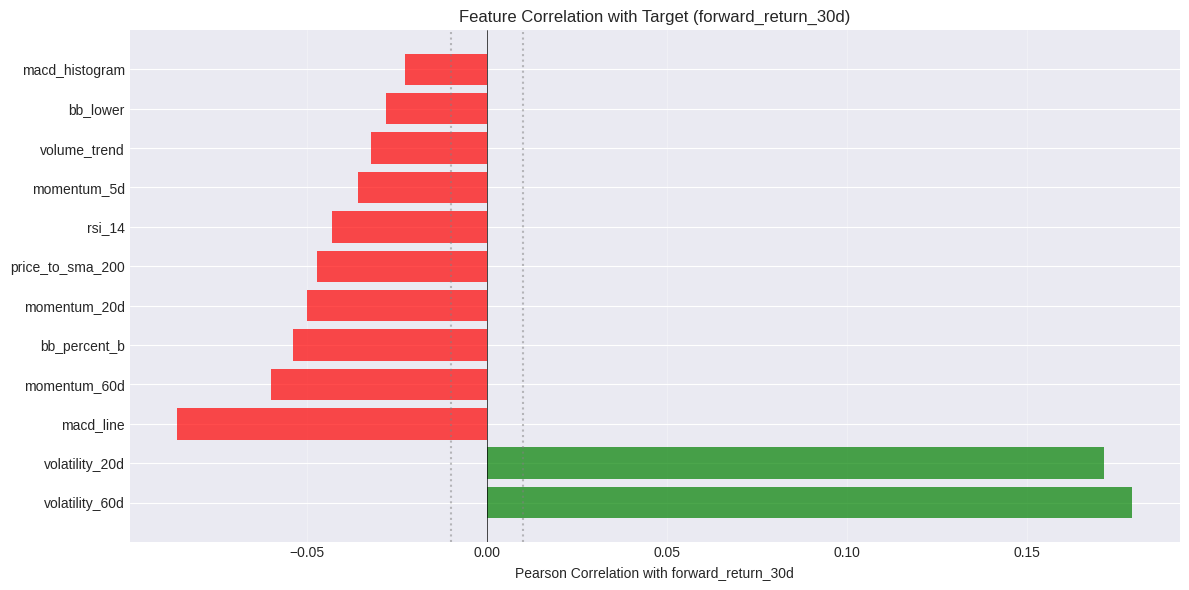

         Feature  Pearson_r    Abs_r
  volatility_60d   0.179167 0.179167
  volatility_20d   0.171199 0.171199
       macd_line  -0.086018 0.086018
    momentum_60d  -0.060011 0.060011
    bb_percent_b  -0.053916 0.053916
    momentum_20d  -0.049950 0.049950
price_to_sma_200  -0.047127 0.047127
          rsi_14  -0.043021 0.043021
     momentum_5d  -0.035785 0.035785
    volume_trend  -0.032253 0.032253
        bb_lower  -0.027987 0.027987
  macd_histogram  -0.022795 0.022795


In [51]:
# Pearson correlation with target
target_corr_remaining = X_analysis[remaining_after_vif].corrwith(y_analysis)
target_corr_df = pd.DataFrame({
    'Feature': target_corr_remaining.index,
    'Pearson_r': target_corr_remaining.values,
    'Abs_r': target_corr_remaining.abs().values
}).sort_values('Abs_r', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(12, max(6, len(target_corr_df) * 0.3)))
colors = ['green' if r > 0 else 'red' for r in target_corr_df['Pearson_r']]
ax.barh(range(len(target_corr_df)), target_corr_df['Pearson_r'], color=colors, alpha=0.7)
ax.set_yticks(range(len(target_corr_df)))
ax.set_yticklabels(target_corr_df['Feature'])
ax.axvline(0, color='black', linewidth=0.5)
ax.axvline(TARGET_CORR_MIN, color='gray', linestyle=':', alpha=0.5)
ax.axvline(-TARGET_CORR_MIN, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel(f'Pearson Correlation with {TARGET}')
ax.set_title(f'Feature Correlation with Target ({TARGET})')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(target_corr_df.to_string(index=False))

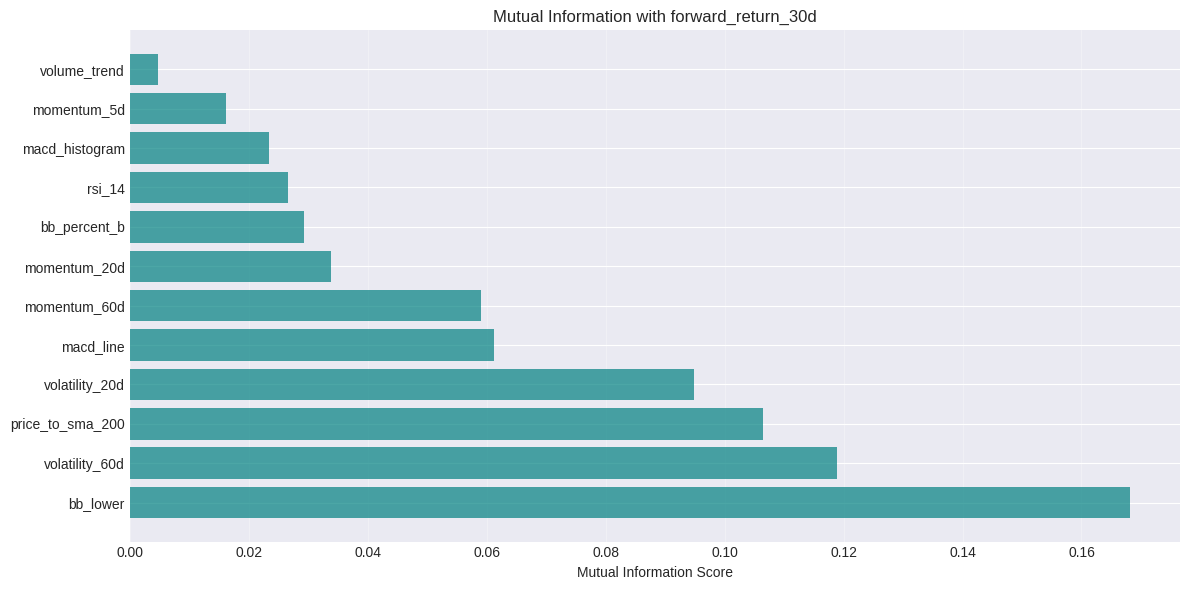

         Feature  MI_Score
        bb_lower  0.168151
  volatility_60d  0.118939
price_to_sma_200  0.106418
  volatility_20d  0.094947
       macd_line  0.061170
    momentum_60d  0.058997
    momentum_20d  0.033845
    bb_percent_b  0.029271
          rsi_14  0.026653
  macd_histogram  0.023385
     momentum_5d  0.016277
    volume_trend  0.004751


In [52]:
# Mutual information (captures non-linear relationships)
X_mi = X_analysis[remaining_after_vif].values
mi_scores = mutual_info_regression(X_mi, y_analysis, random_state=42, n_neighbors=5)

mi_df = pd.DataFrame({
    'Feature': remaining_after_vif,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

fig, ax = plt.subplots(figsize=(12, max(6, len(mi_df) * 0.3)))
ax.barh(range(len(mi_df)), mi_df['MI_Score'], color='teal', alpha=0.7)
ax.set_yticks(range(len(mi_df)))
ax.set_yticklabels(mi_df['Feature'])
ax.set_xlabel('Mutual Information Score')
ax.set_title(f'Mutual Information with {TARGET}')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(mi_df.to_string(index=False))

In [53]:
# Drop features with near-zero target correlation AND near-zero MI
weak_features = set()
for feat in remaining_after_vif:
    abs_corr = target_corr_remaining[feat] if feat in target_corr_remaining.index else 0
    mi = mi_df.loc[mi_df['Feature'] == feat, 'MI_Score'].values
    mi_val = mi[0] if len(mi) > 0 else 0
    
    if abs(abs_corr) < TARGET_CORR_MIN and mi_val < 0.001:
        weak_features.add(feat)
        print(f'  Weak feature: {feat} (|r|={abs(abs_corr):.4f}, MI={mi_val:.4f})')

print(f'\nWeak features to drop: {len(weak_features)}')
selected_features = [c for c in remaining_after_vif if c not in weak_features]
print(f'Selected features: {len(selected_features)}')


Weak features to drop: 0
Selected features: 12


## 5. Feature Selection Summary

In [54]:
print('Feature Selection Summary')
print('=' * 60)
print(f'Original features:           {len(numeric_features)}')
print(f'Dropped (constant):          {len(constant_cols)}')
print(f'Dropped (high correlation):  {len(features_to_drop_corr)}')
print(f'Dropped (high VIF):          {len(features_to_drop_vif)}')
print(f'Dropped (weak signal):       {len(weak_features)}')
print(f'Final selected features:     {len(selected_features)}')
print('=' * 60)
print(f'\nSelected features:')
for i, f in enumerate(selected_features, 1):
    r_val = target_corr_remaining.get(f, 0)
    mi_val = mi_df.loc[mi_df['Feature'] == f, 'MI_Score'].values
    mi_str = f'{mi_val[0]:.4f}' if len(mi_val) > 0 else 'N/A'
    print(f'  {i:2d}. {f:<30s}  r={r_val:+.4f}  MI={mi_str}')

Feature Selection Summary
Original features:           17
Dropped (constant):          3
Dropped (high correlation):  3
Dropped (high VIF):          2
Dropped (weak signal):       0
Final selected features:     12

Selected features:
   1. momentum_5d                     r=-0.0358  MI=0.0163
   2. momentum_20d                    r=-0.0500  MI=0.0338
   3. momentum_60d                    r=-0.0600  MI=0.0590
   4. volatility_20d                  r=+0.1712  MI=0.0949
   5. volatility_60d                  r=+0.1792  MI=0.1189
   6. rsi_14                          r=-0.0430  MI=0.0267
   7. macd_line                       r=-0.0860  MI=0.0612
   8. macd_histogram                  r=-0.0228  MI=0.0234
   9. bb_lower                        r=-0.0280  MI=0.1682
  10. bb_percent_b                    r=-0.0539  MI=0.0293
  11. price_to_sma_200                r=-0.0471  MI=0.1064
  12. volume_trend                    r=-0.0323  MI=0.0048


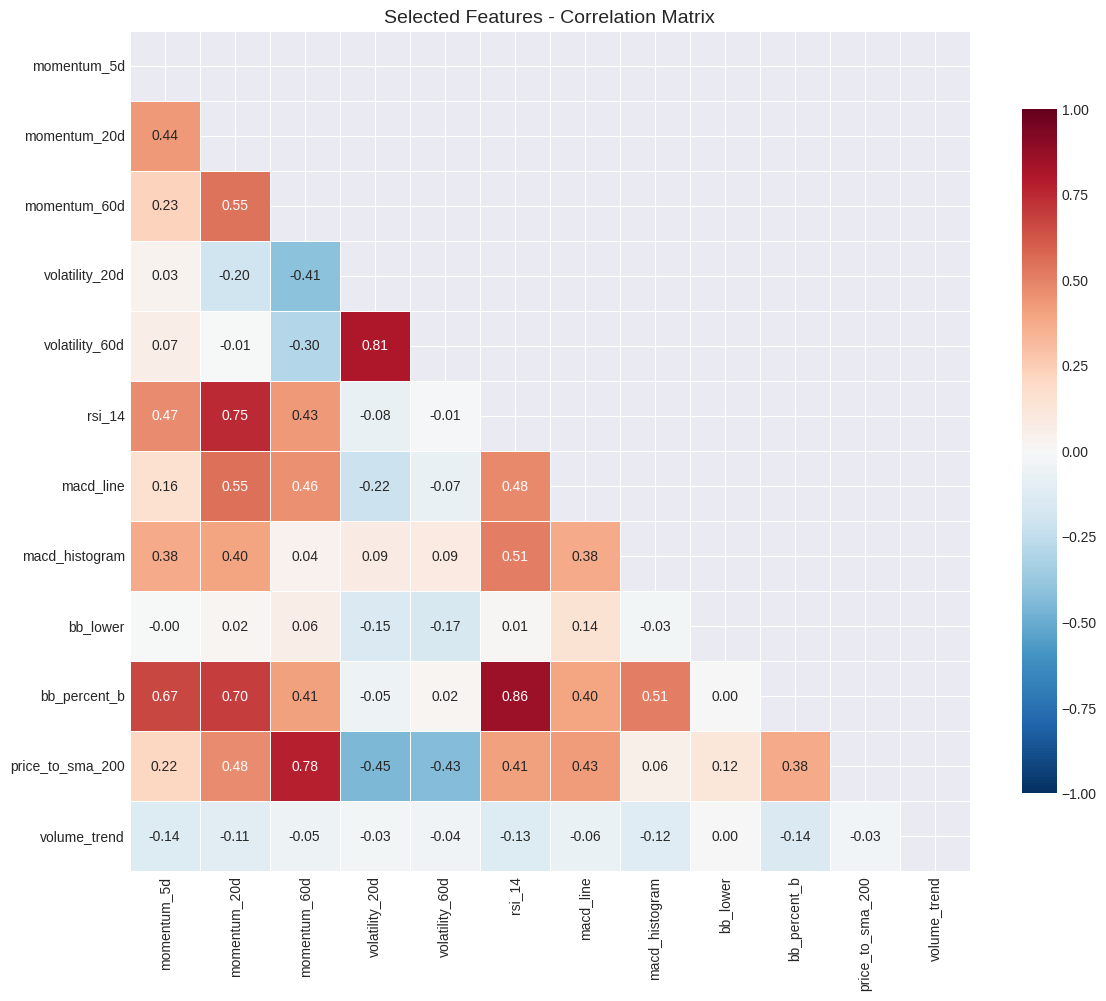

In [55]:
# Final correlation heatmap of selected features
if len(selected_features) > 1:
    fig, ax = plt.subplots(figsize=(12, 10))
    final_corr = X_analysis[selected_features].corr()
    mask_final = np.triu(np.ones_like(final_corr, dtype=bool))
    sns.heatmap(final_corr, mask=mask_final, cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, annot=True, fmt='.2f', square=True,
                linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8})
    ax.set_title('Selected Features - Correlation Matrix', fontsize=14)
    plt.tight_layout()
    plt.show()

## 6. Prepare Data for Training

In [56]:
# Extract features and target
X_train = train_df[selected_features].copy()
y_train = train_df[TARGET].copy()
X_val = val_df[selected_features].copy()
y_val = val_df[TARGET].copy()
X_test = test_df[selected_features].copy()
y_test = test_df[TARGET].copy()

# Fill missing values with training median
train_medians = X_train.median()
X_train = X_train.fillna(train_medians)
X_val = X_val.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Drop rows where target is NaN
train_mask = ~y_train.isna()
val_mask = ~y_val.isna()
test_mask = ~y_test.isna()
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_val, y_val = X_val[val_mask], y_val[val_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

print(f'Train: {X_train.shape}')
print(f'Val:   {X_val.shape}')
print(f'Test:  {X_test.shape}')

Train: (11580, 12)
Val:   (1240, 12)
Test:  (980, 12)


In [57]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'Scaled stats (train): mean={X_train_scaled.mean():.6f}, std={X_train_scaled.std():.4f}')

# Save scaler
joblib.dump(scaler, MODEL_DIR / 'scaler_selected.pkl')
print(f'✓ Scaler saved')

Scaled stats (train): mean=0.000000, std=1.0000
✓ Scaler saved


## 7. Train Models

In [58]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (α=1.0)': Ridge(alpha=1.0, random_state=42),
    'Ridge (α=10.0)': Ridge(alpha=10.0, random_state=42),
    'Ridge (α=100.0)': Ridge(alpha=100.0, random_state=42),
    'Lasso (α=0.001)': Lasso(alpha=0.001, random_state=42, max_iter=10000),
    'Lasso (α=0.01)': Lasso(alpha=0.01, random_state=42, max_iter=10000),
    'ElasticNet (α=0.01)': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000),
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_tr_pred = model.predict(X_train_scaled)
    y_v_pred = model.predict(X_val_scaled)
    
    tr_rmse = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    v_rmse = np.sqrt(mean_squared_error(y_val, y_v_pred))
    tr_r2 = r2_score(y_train, y_tr_pred)
    v_r2 = r2_score(y_val, y_v_pred)
    tr_mae = mean_absolute_error(y_train, y_tr_pred)
    v_mae = mean_absolute_error(y_val, y_v_pred)
    
    results.append({
        'Model': name,
        'Train RMSE': tr_rmse, 'Val RMSE': v_rmse,
        'Train MAE': tr_mae, 'Val MAE': v_mae,
        'Train R²': tr_r2, 'Val R²': v_r2,
        'model_obj': model
    })
    print(f'{name:30s}  Train RMSE={tr_rmse:.6f}  Val RMSE={v_rmse:.6f}  Val R²={v_r2:.6f}')

results_df = pd.DataFrame(results)
print('\n✓ All models trained')

Linear Regression               Train RMSE=0.108923  Val RMSE=0.068704  Val R²=-0.316068
Ridge (α=1.0)                   Train RMSE=0.108923  Val RMSE=0.068704  Val R²=-0.316050
Ridge (α=10.0)                  Train RMSE=0.108923  Val RMSE=0.068699  Val R²=-0.315887
Ridge (α=100.0)                 Train RMSE=0.108924  Val RMSE=0.068659  Val R²=-0.314364
Lasso (α=0.001)                 Train RMSE=0.109031  Val RMSE=0.068462  Val R²=-0.306804
Lasso (α=0.01)                  Train RMSE=0.110340  Val RMSE=0.067350  Val R²=-0.264701
ElasticNet (α=0.01)             Train RMSE=0.109825  Val RMSE=0.069061  Val R²=-0.329795

✓ All models trained


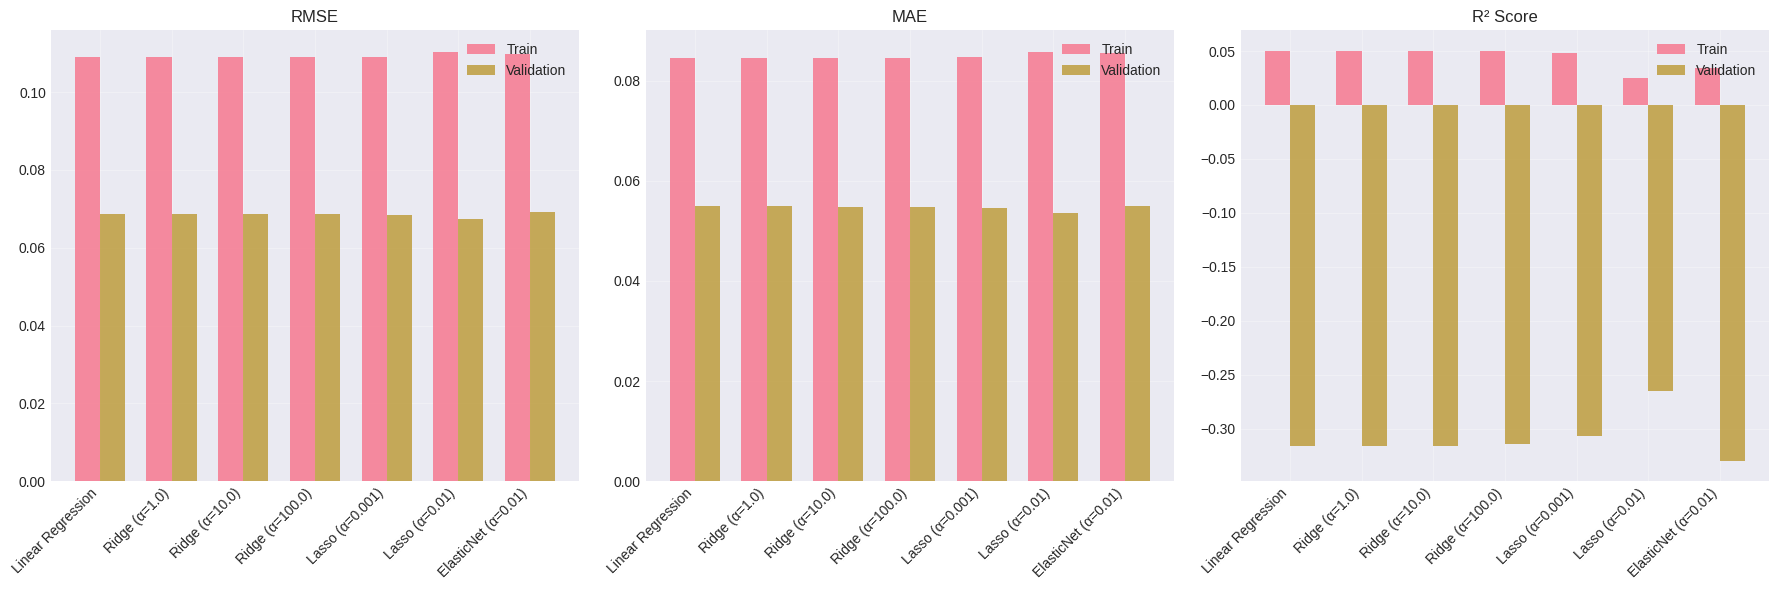

In [59]:
# Model comparison plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
x = np.arange(len(results_df))
w = 0.35

for ax, metric, title in zip(axes, 
    [('Train RMSE', 'Val RMSE'), ('Train MAE', 'Val MAE'), ('Train R²', 'Val R²')],
    ['RMSE', 'MAE', 'R² Score']):
    ax.bar(x - w/2, results_df[metric[0]], w, label='Train', alpha=0.8)
    ax.bar(x + w/2, results_df[metric[1]], w, label='Validation', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Best Model Analysis

In [60]:
# Select best model by validation RMSE
best_idx = results_df['Val RMSE'].idxmin()
best_name = results_df.loc[best_idx, 'Model']
best_model = results_df.loc[best_idx, 'model_obj']

print(f'🏆 Best Model: {best_name}')
print(f'   Val RMSE: {results_df.loc[best_idx, "Val RMSE"]:.6f}')
print(f'   Val R²:   {results_df.loc[best_idx, "Val R²"]:.6f}')

# Test set evaluation
y_test_pred = best_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'\n   Test RMSE: {test_rmse:.6f}')
print(f'   Test MAE:  {test_mae:.6f}')
print(f'   Test R²:   {test_r2:.6f}')

🏆 Best Model: Lasso (α=0.01)
   Val RMSE: 0.067350
   Val R²:   -0.264701

   Test RMSE: 0.090361
   Test MAE:  0.071878
   Test R²:   -0.437175


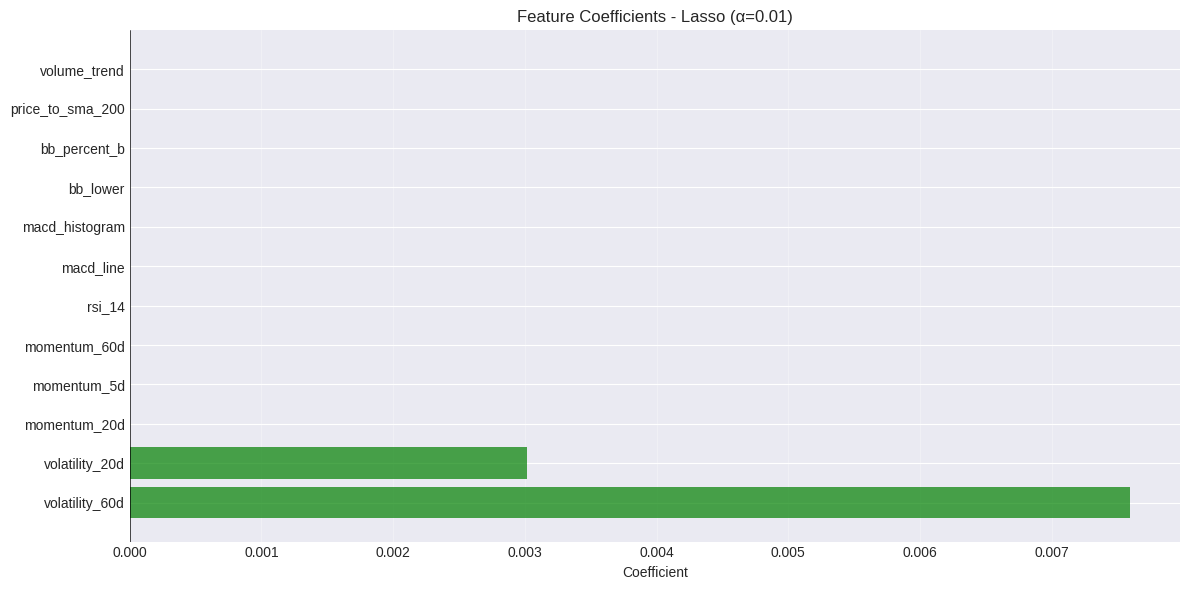

Non-zero coefficients: 2/12
         Feature  Coefficient  Abs_Coef
  volatility_60d     0.007594  0.007594
  volatility_20d     0.003017  0.003017
    momentum_20d    -0.000000  0.000000
     momentum_5d    -0.000000  0.000000
    momentum_60d    -0.000000  0.000000
          rsi_14    -0.000000  0.000000
       macd_line    -0.000000  0.000000
  macd_histogram    -0.000000  0.000000
        bb_lower    -0.000000  0.000000
    bb_percent_b    -0.000000  0.000000
price_to_sma_200    -0.000000  0.000000
    volume_trend    -0.000000  0.000000


In [61]:
# Feature coefficients from best model
if hasattr(best_model, 'coef_'):
    coef_df = pd.DataFrame({
        'Feature': selected_features,
        'Coefficient': best_model.coef_,
        'Abs_Coef': np.abs(best_model.coef_)
    }).sort_values('Abs_Coef', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(coef_df) * 0.35)))
    colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
    ax.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(coef_df)))
    ax.set_yticklabels(coef_df['Feature'])
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Coefficient')
    ax.set_title(f'Feature Coefficients - {best_name}')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    non_zero = (coef_df['Abs_Coef'] > 1e-10).sum()
    print(f'Non-zero coefficients: {non_zero}/{len(selected_features)}')
    print(coef_df.to_string(index=False))

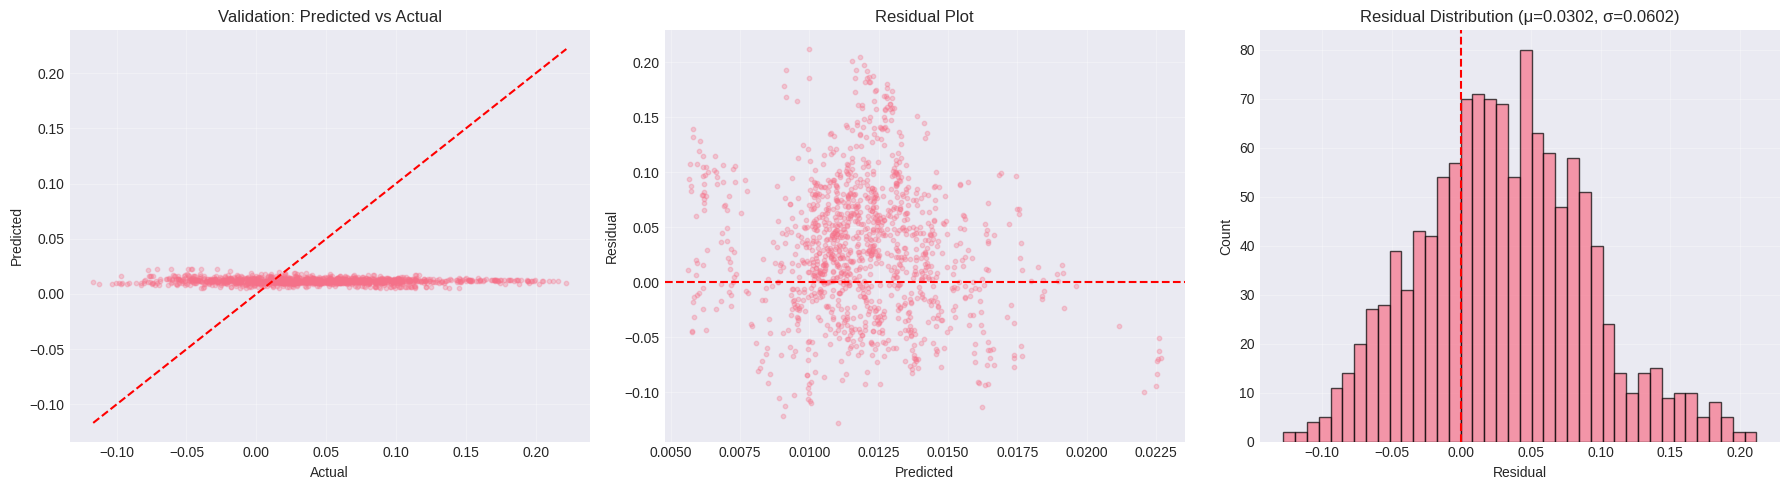

In [62]:
# Prediction vs actual and residuals
y_val_pred = best_model.predict(X_val_scaled)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted vs actual
axes[0].scatter(y_val, y_val_pred, alpha=0.3, s=10)
lims = [min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())]
axes[0].plot(lims, lims, 'r--', lw=1.5)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Validation: Predicted vs Actual')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_val - y_val_pred
axes[1].scatter(y_val_pred, residuals, alpha=0.3, s=10)
axes[1].axhline(0, color='red', linestyle='--', lw=1.5)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

# Residual distribution
axes[2].hist(residuals, bins=40, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--', lw=1.5)
axes[2].set_xlabel('Residual')
axes[2].set_ylabel('Count')
axes[2].set_title(f'Residual Distribution (μ={residuals.mean():.4f}, σ={residuals.std():.4f})')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Best Model & Artifacts

In [63]:
# Save model
model_path = MODEL_DIR / 'best_linear_model.pkl'
joblib.dump(best_model, model_path)
print(f'✓ Model saved to {model_path}')

# Save selected feature names
features_path = MODEL_DIR / 'selected_features.json'
with open(features_path, 'w') as f:
    json.dump({
        'selected_features': selected_features,
        'n_features': len(selected_features),
        'dropped_high_corr': list(features_to_drop_corr),
        'dropped_high_vif': list(features_to_drop_vif),
        'dropped_weak': list(weak_features),
        'selection_params': {
            'corr_threshold': CORR_THRESHOLD,
            'vif_threshold': VIF_THRESHOLD,
            'target_corr_min': TARGET_CORR_MIN
        }
    }, f, indent=2)
print(f'✓ Feature selection saved to {features_path}')

# Save model metadata
metadata = {
    'model_name': best_name,
    'target': TARGET,
    'n_features_original': len(numeric_features),
    'n_features_selected': len(selected_features),
    'train_size': len(X_train),
    'val_rmse': float(results_df.loc[best_idx, 'Val RMSE']),
    'val_r2': float(results_df.loc[best_idx, 'Val R²']),
    'test_rmse': float(test_rmse),
    'test_r2': float(test_r2),
}
meta_path = MODEL_DIR / 'model_metadata.json'
with open(meta_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f'✓ Metadata saved to {meta_path}')

print(f'\n{"="*60}')
print(f'Best Model: {best_name}')
print(f'Features: {len(selected_features)}/{len(numeric_features)} selected')
print(f'Val RMSE:  {results_df.loc[best_idx, "Val RMSE"]:.6f}')
print(f'Test RMSE: {test_rmse:.6f}')
print(f'{"="*60}')

✓ Model saved to /home/archy/Desktop/Server/FinancialData/model_regime_comparison/models/best_linear_model.pkl
✓ Feature selection saved to /home/archy/Desktop/Server/FinancialData/model_regime_comparison/models/selected_features.json
✓ Metadata saved to /home/archy/Desktop/Server/FinancialData/model_regime_comparison/models/model_metadata.json

Best Model: Lasso (α=0.01)
Features: 12/17 selected
Val RMSE:  0.067350
Test RMSE: 0.090361
